In [1]:
import glob

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from astropy.io import fits


In [2]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly import subplots
from plotly  import __version__
print(__version__)

py.offline.init_notebook_mode(connected=True)

4.4.1


In [3]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pylab as plt


In [4]:
from inst.inst_TLS import Spectrum, Tpl, FTS
import vpr


In [5]:
import numpy as np
from scipy import interpolate


c = 3e5   # [km/s] speed of light

# IP sampling in velocity space
# index k for IP space
def IP(vk, s=2.2):
    IP_k = np.exp(-(vk/s)**2)   # Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k


class model:
    '''
    The forward model
    
    '''
    def __init__(self, *args, IP_hw=50):
        self.S_star, self.xj, self.iod_j, self.IP = args
        # convolving with IP will reduce the valid wavelength range
        self.dx = self.xj[1] - self.xj[0]  # sampling in uniform resampled Iod
        self.vk = np.arange(-IP_hw,IP_hw+1) * self.dx * c
        self.xj_eff = self.xj[IP_hw:-IP_hw]
        #print("sampling [km/s]:", self.dx*c)

    def __call__(self, i, v, a, b, s):
        # wavelength solution
        xi = np.log(np.poly1d(b[::-1])(i))
        # IP convolution
        Sj_eff = np.convolve(self.IP(self.vk, s), self.S_star(self.xj+v/c) * self.iod_j, mode='valid')
        # sampling to pixel
        Si_eff = interpolate.interp1d(self.xj_eff, Sj_eff)(xi)
        # flux normalisation
        Si_mod = np.poly1d(a[::-1])(xi) * Si_eff
        return Si_mod
    


def show_model(x, y, ymod, res=True,x2=1):
    if res:
        rms = np.std(y-ymod)

        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='observed',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='modelled',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))

        trace2 = go.Scatter(x=x,
                           y=y-ymod,
                           mode='markers',
                           name='residual spectrum',
                           marker=dict(size=12,color='rgba(0,190,255,0.9)'))

        fig = subplots.make_subplots(rows=2,
                                 cols=1,
                                 subplot_titles=('Model','residual'))

        fig.append_trace(trace0,1,1)
        fig.add_trace(trace1,1,1)

        fig.append_trace(trace2,2,1)

        fig.layout.update(title="Modelling of the spectrum")

        iplot(fig)
        
    else:
        rms = np.std(y-ymod)

        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='observed',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='modelled',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))


        fig = subplots.make_subplots(rows=1,
                                 cols=1,
                                 subplot_titles=('Model'))

        
        fig.append_trace(trace0,1,1)
        fig.add_trace(trace1,1,1)


        fig.layout.update(title="Modelling of the spectrum")

        iplot(fig)

In [6]:
c = 3e5   # [km/s] speed of light

o = 18; lmin = 5240; lmax = 5390

dirname = r''
v0 = -12
ftsname = dirname + 'lib/TLS/FTS/TLS_I2_FTS.fits'
obsname = dirname + 'data/TLS/betgem/BETA_GEM.fits'
tplname = dirname + 'data/TLS/betgem/pepsib.20150409.000.sxt.awl.all6'
obsname = dirname + 'data/TLS/hd189733/TV00001.fits'
tplname = dirname + 'data/TLS/Deconv/HD189733.model'
tplname = dirname + 'data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'

nset = None


In [7]:
####  FTS  ####

# using the supersampled log(wavelength) space with knot index j

w_I2, f_I2, xj_full, iod_j_full = FTS()



ID      ='File ratio of scans 002 & 001                                       '  [astropy.io.fits.card]
DAY     ='07/24/01  '           / Date (mm/dd/yy, MST)                           [astropy.io.fits.card]


In [8]:

orders = np.r_[18:19] # np.arange(18,30)
print(orders)


[18]


In [9]:
rv = np.empty_like(orders*1.) * np.nan
e_rv = np.empty_like(orders*1.) * np.nan



In [10]:
obsname = '/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/hd189733/TV00001.fits'

In [11]:
tplname='/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'

In [12]:
####  data TLS  ####
w_i, f_i, bp, bjd, berv = Spectrum(obsname, o=o)
i = np.arange(f_i.size)

####  stellar template  ####
w_tpl, f_tpl = Tpl(tplname, o=o)

lmin = max(w_tpl[0], w_i[0], w_I2[0])
lmax = min(w_tpl[-1], w_i[-1], w_I2[-1])

# display
# pre-look raw input
s = slice(*np.searchsorted(w_I2, [lmin, lmax]))
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))



In [13]:
obsname = '/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/hd189733/TV00001.fits'

tplname='/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'

####  data TLS  ####
w_i, f_i, bp, bjd, berv = Spectrum(obsname, o=o)
i = np.arange(f_i.size)

####  stellar template  ####
w_tpl, f_tpl = Tpl(tplname, o=o)

lmin = max(w_tpl[0], w_i[0], w_I2[0])
lmax = min(w_tpl[-1], w_i[-1], w_I2[-1])

# display
# pre-look raw input
s = slice(*np.searchsorted(w_I2, [lmin, lmax]))
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))



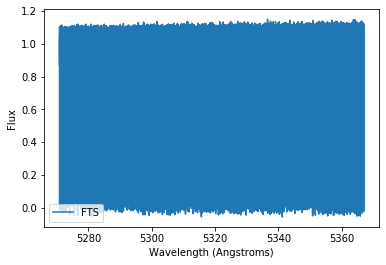

In [14]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

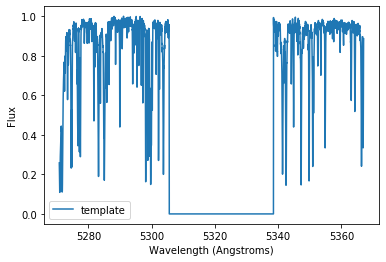

In [17]:
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))

plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label='template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

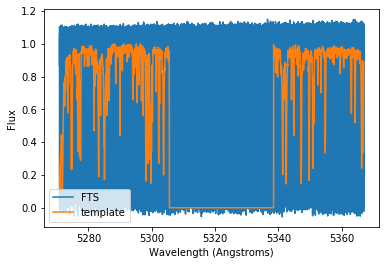

In [18]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label='template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

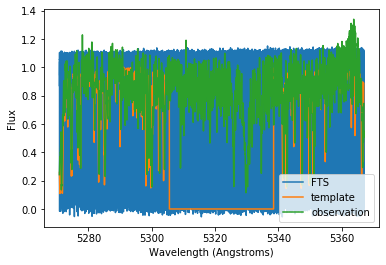

In [19]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label= 'template')
plt.plot(w_i, f_i, label='observation')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()
plt.legend()
